In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

## Data exploration

There are two datasets given: `train.csv` and `test.csv`. Download `train` and explore the given data.

In [2]:
df = pd.read_csv("data/train.csv", parse_dates=[1, 2, 6])
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaT,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaT,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaT,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


We have the following information:
* Deal_id - id of order
* Deal_date - date of order
* First_deal_date - date of the first order
* Secret_dwarf_info_1(/2/3) - secured info about dwarf
* First_default_date - first default date
* Successful_deals_count - number of paid orders
* Region - tavern region
* Tavern - tavern type (based on description this is a categorical column)
* Hashed_deal_detail_1(/2/3/4/5/6) - secured info about order
* Age - dwarf's age
* Gender - dwarf's gender
* Default - target column (1 for positive class and 0 for negative one)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Deal_id                 3168 non-null   int64         
 1   Deal_date               3168 non-null   datetime64[ns]
 2   First_deal_date         3168 non-null   datetime64[ns]
 3   Secret_dwarf_info_1     535 non-null    float64       
 4   Secret_dwarf_info_2     535 non-null    float64       
 5   Secret_dwarf_info_3     535 non-null    float64       
 6   First_default_date      535 non-null    datetime64[ns]
 7   Successful_deals_count  3154 non-null   float64       
 8   Region                  3161 non-null   object        
 9   Tavern                  3168 non-null   int64         
 10  Hashed_deal_detail_1    3168 non-null   float64       
 11  Hashed_deal_detail_2    3168 non-null   int64         
 12  Hashed_deal_detail_3    3168 non-null   int64   

The columns `Secret_dwarf_info_1`, `Secret_dwarf_info_2`, `Secret_dwarf_info_3`, `First_default_date` have lots of NaN values. For `First_default_date` this is a sign that the dwarf didn't have default, so we can fill in NaN values with 0. What should we do with the rest?

As I said 'Tavern' should be a categorical feature so we change value type.

In [4]:
df['Tavern'] = df['Tavern'].astype('object') 

Find out correlation between numeric features and target.

In [5]:
num_cols = ['Secret_dwarf_info_1', 
            'Secret_dwarf_info_2', 
            'Secret_dwarf_info_3', 
            'Successful_deals_count', 
            'Hashed_deal_detail_1', 
            'Hashed_deal_detail_2', 
            'Hashed_deal_detail_3', 
            'Hashed_deal_detail_4', 
            'Hashed_deal_detail_5', 
            'Hashed_deal_detail_6', 
            'Default']

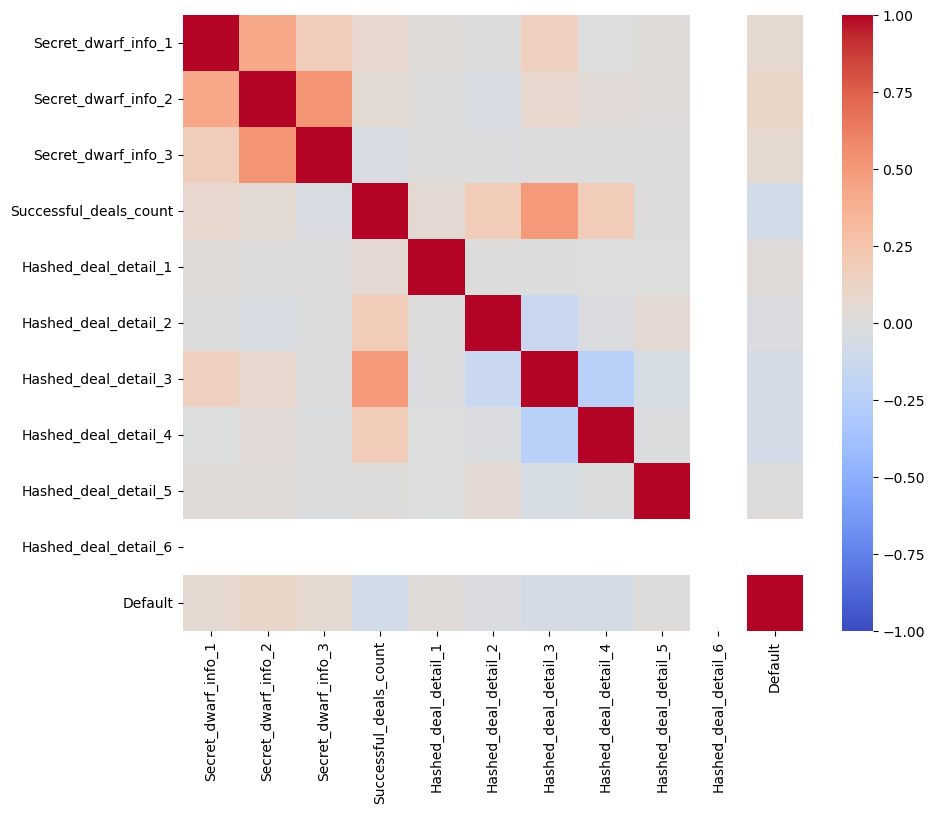

In [6]:
correlation_matrix = df[num_cols].corr()
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

There is a strange line in 'Hashed_deal_detail_6'. What are the values in this column? If it is we can drop it.

In [7]:
df.Hashed_deal_detail_6.unique()

array([5], dtype=int64)

It seems that all the objects have the same value in this column. This does not give any additional information, therefore we can drop this column.
Otherwise, the data looks normal. 

In [8]:
df = df.drop('Hashed_deal_detail_6', axis=1)

Look at the categorical features distribution and compare it within target value.

In [9]:
cat_cols = ['Region', 
            'Tavern', 
            'Age', 
            'Gender']

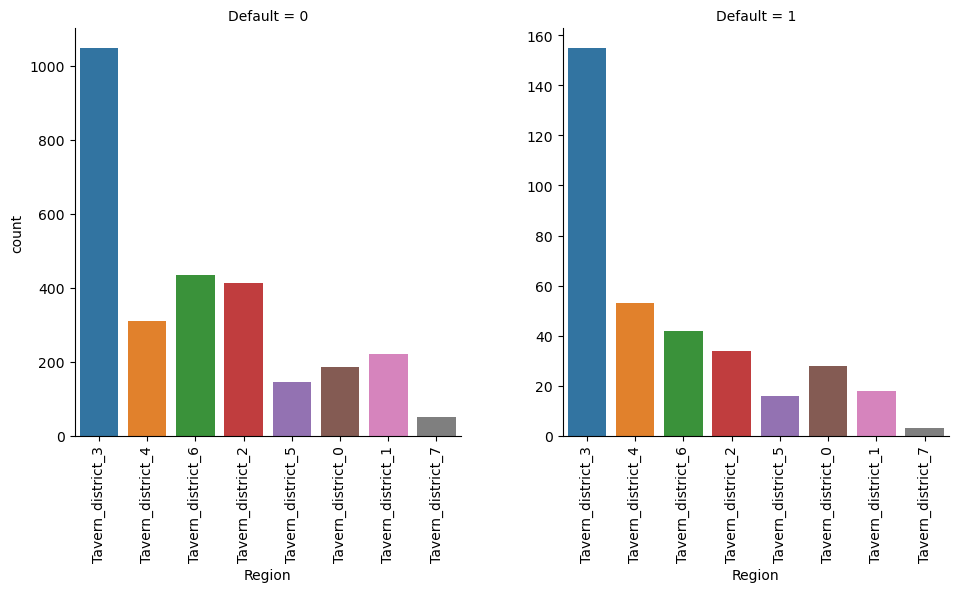

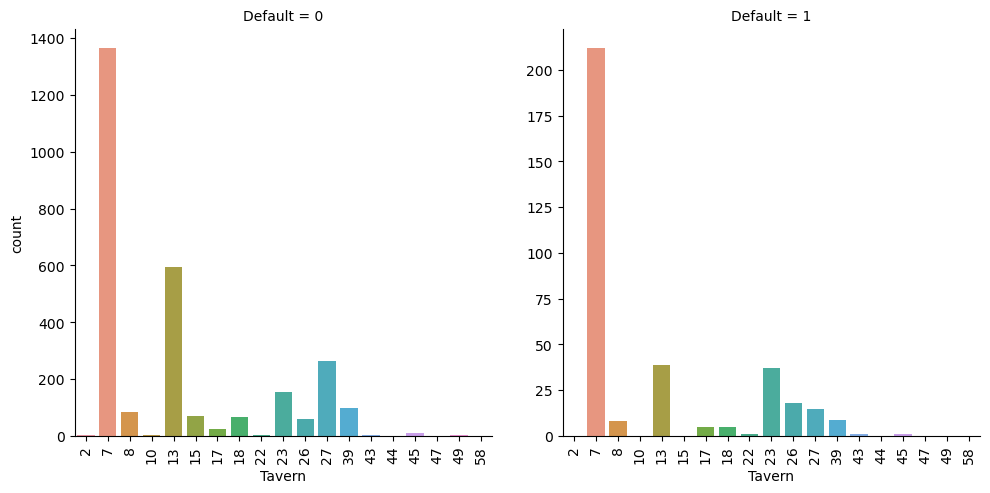

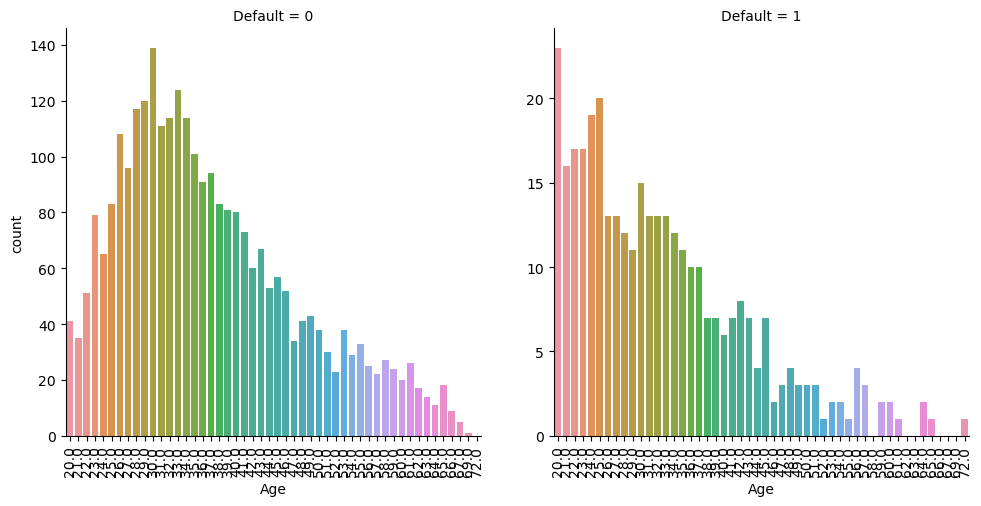

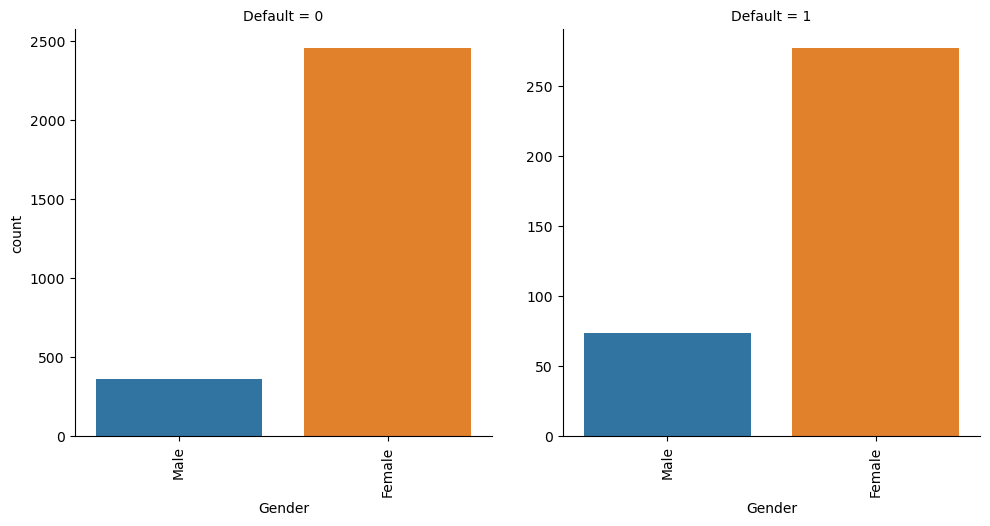

In [10]:
for col in df[cat_cols]:
    g = sns.catplot(x=col, kind='count', col='Default', data=df, sharey=False)
    g.set_xticklabels(rotation=90)
    plt.show()

**Conclusions:**
1. Age is very important feature: younger dwarfs have more defaults.
2. Tavern region is also important. Despite the imbalance in regions some of the them are more common to have default deals (such as district 4, for instance). 
3. Men dwarfs are more likely to default.
We will keep all the columns.

**Dealing with time data**

***Idea 1:*** Seasons must affect target. Let's extract month of the order and and a year as different categories.<br>
***Idea 2:*** It seems like regular customers should have lower default rate. We can also use time interval between date of the current order and the first order. <br>
***Idea 3:*** Time passed after the first default order must metter. More time passed - more circumstances could have changed. We can calculate the difference in days between these dates. <br>
After that we can drop all the time columns.

Idea: we can calculate mean value of default for each tavern region and use it as a new feature. The new column would be a flag of 'region with a higher risk'. Still this should be done after deviding dataset into train and test part.

In [11]:
date_cols = ['Deal_date',
             'First_deal_date',
             'First_default_date']

In [12]:
df['Deal_month'] = df['Deal_date'].dt.month.astype('object') # Object type to prevent using month as numeric feature
df['Deal_year'] = df['Deal_date'].dt.year
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,Deal_year
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,36.0,Male,0,11,2015
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,29.0,Female,1,8,2016
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaT,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,56.0,Female,0,2,2016
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaT,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,27.0,Female,0,4,2016
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaT,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,37.0,Female,0,9,2016


In [13]:
df.Deal_year.unique()

array([2015, 2016], dtype=int64)

We have only two years in our data. If the target distribution is not significnt we do not need this new column.

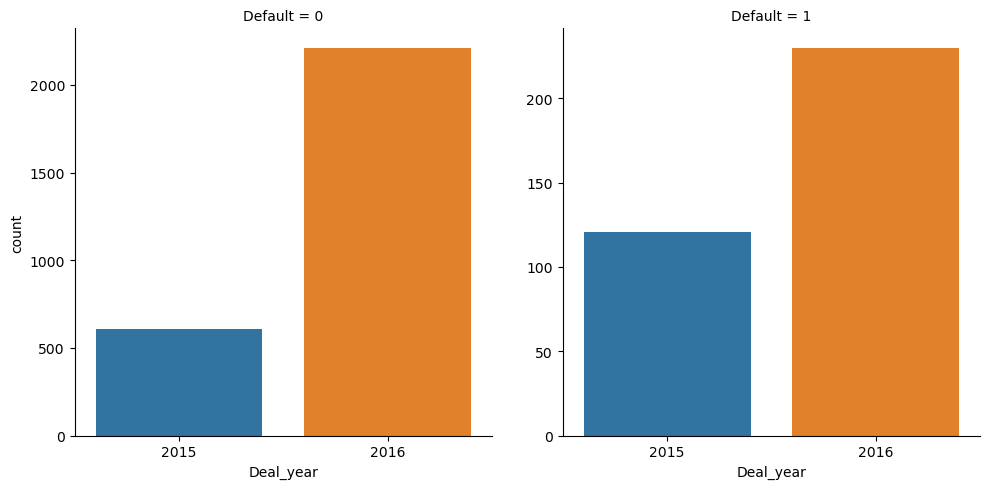

In [14]:
sns.catplot(x='Deal_year', kind='count', col='Default', data=df, sharey=False)

As it can be seen year is important. However, we can keep only one column - 2015 year as the one with more default stats.

In [15]:
df['2015_year'] = (df['Deal_year'] == 2015).astype(int)
df = df.drop('Deal_year', axis = 1)
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,2015_year
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,36.0,Male,0,11,1
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,29.0,Female,1,8,0
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaT,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,56.0,Female,0,2,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaT,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,27.0,Female,0,4,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaT,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,37.0,Female,0,9,0


Add new column of loyalty days - time interval between the first order and the current one.

In [16]:
df['loyalty_days'] = (df['Deal_date'] - df['First_deal_date']).dt.days
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,...,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,2015_year,loyalty_days
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,...,-3,8,2.5,-3,36.0,Male,0,11,1,68
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,...,-3,14,3.5,-3,29.0,Female,1,8,0,249
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaT,0.0,Tavern_district_6,7,...,-3,8,2.5,-3,56.0,Female,0,2,0,99
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaT,0.0,Tavern_district_2,13,...,-2,5,2.5,-3,27.0,Female,0,4,0,39
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaT,0.0,Tavern_district_4,39,...,-3,7,2.5,-3,37.0,Female,0,9,0,60


Add new column of days after default.

In [17]:
df['days_after_first_default'] = (df['Deal_date'] - df['First_default_date']).dt.days
df['days_after_first_default'] = df['days_after_first_default'].fillna(-1)
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,...,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,2015_year,loyalty_days,days_after_first_default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,...,8,2.5,-3,36.0,Male,0,11,1,68,-1.0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,...,14,3.5,-3,29.0,Female,1,8,0,249,27.0
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaT,0.0,Tavern_district_6,7,...,8,2.5,-3,56.0,Female,0,2,0,99,-1.0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaT,0.0,Tavern_district_2,13,...,5,2.5,-3,27.0,Female,0,4,0,39,-1.0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaT,0.0,Tavern_district_4,39,...,7,2.5,-3,37.0,Female,0,9,0,60,-1.0


In [18]:
df = df.drop(date_cols, axis = 1)
df.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,2015_year,loyalty_days,days_after_first_default
0,22487461,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,36.0,Male,0,11,1,68,-1.0
1,62494261,3.5,-2.0,5.0,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,29.0,Female,1,8,0,249,27.0
2,34822849,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,56.0,Female,0,2,0,99,-1.0
3,46893387,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,27.0,Female,0,4,0,39,-1.0
4,67128275,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,37.0,Female,0,9,0,60,-1.0


In [19]:
df = df.set_index('Deal_id') # This should be index
df.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,2015_year,loyalty_days,days_after_first_default
Deal_id,,,,,,,,,,,,,,,,,,
22487461,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,36.0,Male,0,11,1,68,-1.0
62494261,3.5,-2.0,5.0,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,29.0,Female,1,8,0,249,27.0
34822849,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,56.0,Female,0,2,0,99,-1.0
46893387,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,27.0,Female,0,4,0,39,-1.0
67128275,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,37.0,Female,0,9,0,60,-1.0


Check NaN values

In [20]:
df.isna().sum()

Secret_dwarf_info_1         2633
Secret_dwarf_info_2         2633
Secret_dwarf_info_3         2633
Successful_deals_count        14
Region                         7
Tavern                         0
Hashed_deal_detail_1           0
Hashed_deal_detail_2           0
Hashed_deal_detail_3           0
Hashed_deal_detail_4           0
Hashed_deal_detail_5           0
Age                            0
Gender                         0
Default                        0
Deal_month                     0
2015_year                      0
loyalty_days                   0
days_after_first_default       0
dtype: int64

Successful deals we can fill in with 0. Region with the 'unknown' and all the rest with the mode.

In [21]:
df['Successful_deals_count'] = df['Successful_deals_count'].fillna(0)
df['Region'] = df['Region'].fillna('Unknown')
cols_to_fill = ['Secret_dwarf_info_1',
                'Secret_dwarf_info_2',
                'Secret_dwarf_info_3']
for col in df[cols_to_fill]:
    df[col] = df[col].fillna(df[col].mode()[0])
df.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,2015_year,loyalty_days,days_after_first_default
Deal_id,,,,,,,,,,,,,,,,,,
22487461,3.5,-2.0,5.0,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,36.0,Male,0,11,1,68,-1.0
62494261,3.5,-2.0,5.0,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,29.0,Female,1,8,0,249,27.0
34822849,3.5,-2.0,5.0,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,56.0,Female,0,2,0,99,-1.0
46893387,3.5,-2.0,5.0,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,27.0,Female,0,4,0,39,-1.0
67128275,3.5,-2.0,5.0,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,37.0,Female,0,9,0,60,-1.0


Verify that we do not have any NaN values left

In [22]:
df.isna().sum()

Secret_dwarf_info_1         0
Secret_dwarf_info_2         0
Secret_dwarf_info_3         0
Successful_deals_count      0
Region                      0
Tavern                      0
Hashed_deal_detail_1        0
Hashed_deal_detail_2        0
Hashed_deal_detail_3        0
Hashed_deal_detail_4        0
Hashed_deal_detail_5        0
Age                         0
Gender                      0
Default                     0
Deal_month                  0
2015_year                   0
loyalty_days                0
days_after_first_default    0
dtype: int64

Most probably we have an imbalanced data. We have to know the part of default orders.

In [23]:
df[df.Default == 1].Default.sum()

351

In [24]:
len(df) - df[df.Default == 1].Default.sum()

2817

### Training model
We devide the data into train and test part. After that we will add one more column showing ratio of default orders for each region.

In [27]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,
                                     test_size=0.3,
                                     stratify = df['Default'],
                                     random_state=42)

In [28]:
# Calculate the ratio of default for each region in the training data
region_default_ratio = df_train.groupby('Region').apply(lambda x: x['Default'].sum() / len(x)).to_dict()

# Map the ratio to a new column
df_train['region_default_ratio'] = df_train['Region'].map(region_default_ratio)
df_test['region_default_ratio'] = df_test['Region'].map(region_default_ratio)

df_train.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,2015_year,loyalty_days,days_after_first_default,region_default_ratio
Deal_id,,,,,,,,,,,,,,,,,,,
20274428,3.5,-2.0,5.0,0.0,Tavern_district_3,23,2.5,-2,5,2.5,-3,35.0,Female,1,10,1,33,-1.0,0.127059
5503051,3.5,-2.0,5.0,0.0,Tavern_district_3,7,2.5,-3,7,2.5,-3,30.0,Female,0,6,0,90,-1.0,0.127059
61955513,3.5,-2.0,5.0,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,29.0,Female,0,8,0,87,-1.0,0.127059
57389760,3.5,-2.0,5.0,0.0,Tavern_district_3,7,2.5,-3,7,2.5,-3,44.0,Female,0,7,0,89,-1.0,0.127059
49759381,3.5,-2.0,5.0,0.0,Tavern_district_6,39,2.5,-3,8,2.5,-3,23.0,Female,0,5,0,155,-1.0,0.093567


**One more idea**
Probably, number of days after the fisrt order can be different for each dwarf and could very for each tavern type. It could be good idea to calcuate ratio of a particular dwarf loyalty to the average for this tavern.

In [29]:
# Calculate the ratio of loyalty days for each tavern type in the training data
tavern_loyalty_ratio = df_train.groupby('Tavern').apply(lambda x: x['loyalty_days'].sum() / len(x)).to_dict()

# Map the ratio to a new column and calculate ratio of dwarf's loyalty to average
df_train['tavern_loyalty_ratio'] = df_train['Tavern'].map(tavern_loyalty_ratio)
df_train['loyalty_status'] = df_train['loyalty_days'] / df_train['tavern_loyalty_ratio']
df_train = df_train.drop('tavern_loyalty_ratio', axis=1)
df_test['tavern_loyalty_ratio'] = df_test['Tavern'].map(tavern_loyalty_ratio)
df_test['loyalty_status'] = df_test['loyalty_days'] / df_test['tavern_loyalty_ratio']
df_test = df_test.drop('tavern_loyalty_ratio', axis=1)

df_train.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,Deal_month,2015_year,loyalty_days,days_after_first_default,region_default_ratio,loyalty_status
Deal_id,,,,,,,,,,,,,,,,,,,,
20274428,3.5,-2.0,5.0,0.0,Tavern_district_3,23,2.5,-2,5,2.5,-3,35.0,Female,1,10,1,33,-1.0,0.127059,0.277179
5503051,3.5,-2.0,5.0,0.0,Tavern_district_3,7,2.5,-3,7,2.5,-3,30.0,Female,0,6,0,90,-1.0,0.127059,0.500835
61955513,3.5,-2.0,5.0,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,29.0,Female,0,8,0,87,-1.0,0.127059,0.484140
57389760,3.5,-2.0,5.0,0.0,Tavern_district_3,7,2.5,-3,7,2.5,-3,44.0,Female,0,7,0,89,-1.0,0.127059,0.495270
49759381,3.5,-2.0,5.0,0.0,Tavern_district_6,39,2.5,-3,8,2.5,-3,23.0,Female,0,5,0,155,-1.0,0.093567,0.859766


Probably we got all necessary data from 'Region' and we do not need this column any more. We will keep a copy with the region to be able to get back to this option. Now we continue with the 'Regon' column dropped. 

In [30]:
copy_train = df_train.copy()
copy_test = df_test.copy()

df_train = df_train.drop('Region', axis=1)
df_test = df_test.drop('Region', axis=1)

In [31]:
y_train = df_train['Default']
X_train = df_train.drop('Default', axis = 1)

y_test = df_test['Default']
X_test = df_test.drop('Default', axis = 1)

We should encode categorical features

In [32]:
from sklearn.preprocessing import OneHotEncoder

drop_enc = OneHotEncoder(drop='first', handle_unknown='ignore')

X_train_encoded = drop_enc.fit_transform(X_train)
X_test_encoded = drop_enc.transform(X_test)
X_train_encoded

<2217x2069 sparse matrix of type '<class 'numpy.float64'>'
	with 22014 stored elements in Compressed Sparse Row format>

### SVM

Fisrt, we try SVM model.

In [33]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced', probability=True, random_state = 42)
svc.fit(X_train_encoded, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [34]:
from sklearn.metrics import f1_score

svc_preds = svc.predict(X_test_encoded)

f1_score(y_test, svc_preds, average='weighted')

0.8395173375080573

In [35]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, svc_preds)

0.5854272205336035

In [36]:
from sklearn.metrics import recall_score

recall_score(y_test, svc_preds, average='weighted')

0.8412197686645636

In [37]:
from sklearn.metrics import roc_auc_score

probabilities = svc.predict_proba(X_test_encoded)[:, 1]

roc_auc_score(y_test, probabilities)

0.701407182258246

The model shows good enough quality. But we can try other models, for instance, **Random Forest**

### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300, max_depth=5, random_state=42)
rand_forest.fit(X_train_encoded, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       n_estimators=300, random_state=42)

In [39]:
rf_preds = rand_forest.predict(X_test_encoded)

rf_fscore = f1_score(y_test, rf_preds, average='weighted')
print(f'F-score on test data is {round(rf_fscore, 2)}')

rf_bal_ac = balanced_accuracy_score(y_test, rf_preds)
print(f'Balanced accuracy on test data is {round(rf_bal_ac, 2)}')

rf_recall = recall_score(y_test, rf_preds, average='weighted')
print(f'Recall on test data is {round(rf_recall, 2)}')

rf_probabilities = rand_forest.predict_proba(X_test_encoded)[:, 1]
rf_roc_auc = roc_auc_score(y_test, rf_probabilities)
print(f'ROC AUC score on test data is {round(rf_roc_auc, 2)}')

F-score on test data is 0.82
Balanced accuracy on test data is 0.62
Recall on test data is 0.81
ROC AUC score on test data is 0.71


Probably we could find better params using Grid Search. We have an imbalanced dataset, so we try to maximize balanced accuracy.

In [43]:
from sklearn.model_selection import GridSearchCV

rf_parameters_grid = {
    'n_estimators': [10, 100, 200, 500],
    'max_depth': [5, 15, 30]
}

search_rf = GridSearchCV(
    rand_forest,
    rf_parameters_grid,
    scoring="balanced_accuracy",
    return_train_score=True
)

search_rf.fit(X_train_encoded, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              max_depth=5, n_estimators=300,
                                              random_state=42),
             param_grid={'max_depth': [5, 15, 30],
                         'n_estimators': [10, 100, 200, 500]},
             return_train_score=True, scoring='balanced_accuracy')

In [44]:
print(f"Best parameter {search_rf.best_score_:.5f}:")
print(search_rf.best_params_)

Best parameter 0.59992:
{'max_depth': 5, 'n_estimators': 500}


In [45]:
upgr_rf_preds = search_rf.predict(X_test_encoded)

upgr_rf_fscore = f1_score(y_test, upgr_rf_preds, average='weighted')
print(f'F-score on test data is {round(upgr_rf_fscore, 2)}')

upgr_rf_bal_ac = balanced_accuracy_score(y_test, upgr_rf_preds)
print(f'Balanced accuracy on test data is {round(upgr_rf_bal_ac, 2)}')

upgr_rf_recall = recall_score(y_test, upgr_rf_preds, average='weighted')
print(f'Recall on test data is {round(upgr_rf_recall, 2)}')

upgr_rf_probabilities = search_rf.predict_proba(X_test_encoded)[:, 1]
upgr_rf_roc_auc = roc_auc_score(y_test, upgr_rf_probabilities)
print(f'ROC AUC score on test data is {round(upgr_rf_roc_auc, 2)}')

F-score on test data is 0.83
Balanced accuracy on test data is 0.61
Recall on test data is 0.81
ROC AUC score on test data is 0.71


Random Forset Classifier seems to show higher score. <br>
What if we try one decision tree?

### Decision Tree Classifier

In [48]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=0)

tree_parameters_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 15, 20, 30]
}

search_tree = GridSearchCV(
    tree_classifier,
    tree_parameters_grid,
    scoring="balanced_accuracy",
    return_train_score=True
)

search_tree.fit(X_train_encoded, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             param_grid={'max_depth': [5, 10, 15, 20, 30],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='balanced_accuracy')

In [49]:
print(f"Best parameter {search_tree.best_score_:.5f}:")
print(search_tree.best_params_)

Best parameter 0.58194:
{'max_depth': 15, 'splitter': 'best'}


In [50]:
tree_preds = search_tree.predict(X_test_encoded)

tree_fscore = f1_score(y_test, tree_preds, average='weighted')
print(f'F-score on test data is {round(tree_fscore, 2)}')

tree_bal_ac = balanced_accuracy_score(y_test, tree_preds)
print(f'Balanced accuracy on test data is {round(tree_bal_ac, 2)}')

tree_recall = recall_score(y_test, tree_preds, average='weighted')
print(f'Recall on test data is {round(tree_recall, 2)}')

tree_test_accuracy = np.mean(y_test == tree_preds)
tree_train_accuracy = np.mean(y_train == search_tree.predict(X_train_encoded))

print(f'Accuracy on train data is {round(tree_train_accuracy, 2)}')
print(f'Accuracy on test data is {round(tree_test_accuracy, 2)}')

tree_probabilities = search_tree.predict_proba(X_test_encoded)[:, 1]
tree_roc_auc = roc_auc_score(y_test, tree_probabilities)
print(f'ROC AUC score on test data is {round(tree_roc_auc, 2)}')

F-score on test data is 0.82
Balanced accuracy on test data is 0.61
Recall on test data is 0.8
Accuracy on train data is 0.88
Accuracy on test data is 0.8
ROC AUC score on test data is 0.61


One Decision Tree shows lower score than Random Forest.

### LightGBM
We try one advanced model - LightGBM to see if we can have better result.

In [51]:
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier(class_weight='balanced')
lgb_classifier.fit(X_train_encoded, y_train)

LGBMClassifier(class_weight='balanced')

In [52]:
lgb_preds = lgb_classifier.predict(X_test_encoded)

lgb_fscore = f1_score(y_test, lgb_preds, average='weighted')
print(f'F-score on test data is {round(lgb_fscore, 2)}')

lgb_bal_ac = balanced_accuracy_score(y_test, lgb_preds)
print(f'Balanced accuracy on test data is {round(lgb_bal_ac, 2)}')

lgb_recall = recall_score(y_test, lgb_preds, average='weighted')
print(f'Recall on test data is {round(lgb_recall, 2)}')

lgb_test_accuracy = np.mean(y_test == lgb_preds)
lgb_train_accuracy = np.mean(y_train == lgb_classifier.predict(X_train_encoded))

print(f'Accuracy on train data is {round(lgb_train_accuracy, 2)}')
print(f'Accuracy on test data is {round(lgb_test_accuracy, 2)}')

lgb_probabilities = lgb_classifier.predict_proba(X_test_encoded)[:, 1]
lgb_roc_auc = roc_auc_score(y_test, lgb_probabilities)
print(f'ROC AUC score on test data is {round(lgb_roc_auc, 2)}')

F-score on test data is 0.81
Balanced accuracy on test data is 0.6
Recall on test data is 0.78
Accuracy on train data is 0.9
Accuracy on test data is 0.78
ROC AUC score on test data is 0.68


Change some params to improve the performance.

In [54]:
lgb_parameters_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.1, 0.01, 0.001],
    'reg_lambda': [None, 1, 2]
}

search_lgb = GridSearchCV(
    lgb_classifier,
    lgb_parameters_grid,
    scoring="roc_auc",
    return_train_score=True
)

search_lgb.fit(X_train_encoded, y_train)

GridSearchCV(estimator=LGBMClassifier(class_weight='balanced'),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500, 700],
                         'reg_lambda': [None, 1, 2]},
             return_train_score=True, scoring='roc_auc')

In [55]:
best_params = search_lgb.best_params_
print(best_params)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 2}


In [56]:
lgb_preds = search_lgb.predict(X_test_encoded)

lgb_fscore = f1_score(y_test, lgb_preds, average='weighted')
print(f'F-score on test data is {round(lgb_fscore, 2)}')

lgb_bal_ac = balanced_accuracy_score(y_test, lgb_preds)
print(f'Balanced accuracy on test data is {round(lgb_bal_ac, 2)}')

lgb_recall = recall_score(y_test, lgb_preds, average='weighted')
print(f'Recall on test data is {round(lgb_recall, 2)}')

lgb_probabilities = search_lgb.predict_proba(X_test_encoded)[:, 1]
lgb_roc_auc = roc_auc_score(y_test, lgb_probabilities)
print(f'ROC AUC score on test data is {round(lgb_roc_auc, 2)}')

F-score on test data is 0.76
Balanced accuracy on test data is 0.66
Recall on test data is 0.71
ROC AUC score on test data is 0.7


LigthGBM can handle categorical features itself. What if we pass not encoded dataframe but the original one with some extra feaures added?

In [57]:
X_train.head() # Verify that we have dataframe not encoded

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Deal_month,2015_year,loyalty_days,days_after_first_default,region_default_ratio,loyalty_status
Deal_id,,,,,,,,,,,,,,,,,,
20274428,3.5,-2.0,5.0,0.0,23,2.5,-2,5,2.5,-3,35.0,Female,10,1,33,-1.0,0.127059,0.277179
5503051,3.5,-2.0,5.0,0.0,7,2.5,-3,7,2.5,-3,30.0,Female,6,0,90,-1.0,0.127059,0.500835
61955513,3.5,-2.0,5.0,0.0,7,2.5,-3,8,2.5,-3,29.0,Female,8,0,87,-1.0,0.127059,0.484140
57389760,3.5,-2.0,5.0,0.0,7,2.5,-3,7,2.5,-3,44.0,Female,7,0,89,-1.0,0.127059,0.495270
49759381,3.5,-2.0,5.0,0.0,39,2.5,-3,8,2.5,-3,23.0,Female,5,0,155,-1.0,0.093567,0.859766


In [58]:
X_train.Secret_dwarf_info_3.unique()

array([5., 6., 7., 8.])

In [59]:
X_train.Tavern.unique()

array([23, 7, 39, 13, 26, 8, 27, 18, 15, 45, 2, 58, 10, 43, 17, 49, 22,
       44], dtype=object)

In [60]:
X_train.Hashed_deal_detail_3.unique()

array([ 5,  7,  8,  9, 15, 11,  6, 10, 12, 13, 16, 14, 17, 18, 19, 22, 21,
       23, 29, 24, 20, 26], dtype=int64)

In [61]:
categorical_columns = ['Tavern',
                      'Gender',
                      'Hashed_deal_detail_3', # based on int values
                      'Secret_dwarf_info_3', # based on int values
                       'Deal_month']

In [63]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

for col in categorical_columns: 
    X_train[col] = X_train[col].astype('category')
    
lgb_classifier = lgb.LGBMClassifier(class_weight='balanced')  

lgb_parameters_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.1, 0.01],
    'reg_lambda': [None, 1, 2]
}

search_lgb = GridSearchCV(
    lgb_classifier,
    lgb_parameters_grid,
    scoring="balanced_accuracy",
    return_train_score=True,
    verbose = 3
)

search_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.857, test=0.678) total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.858, test=0.630) total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.855, test=0.748) total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.847, test=0.627) total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.851, test=0.636) total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=1;, score=(train=0.843, test=0.685) total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=1;, score=(train=0.853, test=0.676) total time=   0.1s
[CV 3/5] END learnin

[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=None;, score=(train=0.951, test=0.613) total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=None;, score=(train=0.957, test=0.597) total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.945, test=0.620) total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.949, test=0.605) total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.961, test=0.670) total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.952, test=0.611) total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.940, test=0.657) total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=2;, score=(train=

[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=1;, score=(train=0.973, test=0.587) total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=1;, score=(train=0.975, test=0.610) total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=1;, score=(train=0.976, test=0.577) total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=1;, score=(train=0.970, test=0.591) total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=2;, score=(train=0.972, test=0.626) total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=2;, score=(train=0.965, test=0.610) total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=2;, score=(train=0.972, test=0.637) total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=2;, score=(train=0.976,

[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.741, test=0.725) total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.740, test=0.707) total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.739, test=0.688) total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.745, test=0.686) total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.750, test=0.637) total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=300, reg_lambda=None;, score=(train=0.781, test=0.703) total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=300, reg_lambda=None;, score=(train=0.780, test=0.686) total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=300, reg_lambda=None;, sc

[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=2;, score=(train=0.799, test=0.675) total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=2;, score=(train=0.809, test=0.626) total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.863, test=0.667) total time=   0.8s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.873, test=0.653) total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.871, test=0.716) total time=   0.8s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.869, test=0.619) total time=   0.8s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.870, test=0.637) total time=   0.8s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=

[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.929, test=0.626) total time=   1.1s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.938, test=0.703) total time=   1.3s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.931, test=0.623) total time=   1.3s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.909, test=0.660) total time=   1.2s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=1;, score=(train=0.911, test=0.659) total time=   1.1s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=1;, score=(train=0.925, test=0.612) total time=   1.2s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=1;, score=(train=0.929, test=0.701) total time=   1.3s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=1;,

GridSearchCV(estimator=LGBMClassifier(class_weight='balanced'),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500, 700],
                         'reg_lambda': [None, 1, 2]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [64]:
best_params = search_lgb.best_params_
print(best_params)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 2}


Check all the metrics

In [65]:
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score, roc_auc_score

for col in categorical_columns: 
    X_test[col] = X_test[col].astype('category')
    
lgb_preds = search_lgb.predict(X_test)

lgb_fscore = f1_score(y_test, lgb_preds, average='weighted')
print(f'F-score on test data is {round(lgb_fscore, 2)}')

lgb_bal_ac = balanced_accuracy_score(y_test, lgb_preds)
print(f'Balanced accuracy on test data is {round(lgb_bal_ac, 2)}')

lgb_recall = recall_score(y_test, lgb_preds, average='weighted')
print(f'Recall on test data is {round(lgb_recall, 2)}')

lgb_probabilities = search_lgb.predict_proba(X_test)[:, 1]
lgb_roc_auc = roc_auc_score(y_test, lgb_probabilities)
print(f'ROC AUC score on test data is {round(lgb_roc_auc, 2)}')

F-score on test data is 0.77
Balanced accuracy on test data is 0.66
Recall on test data is 0.72
ROC AUC score on test data is 0.74


Look at feature importances to see if we can make any conclusions.

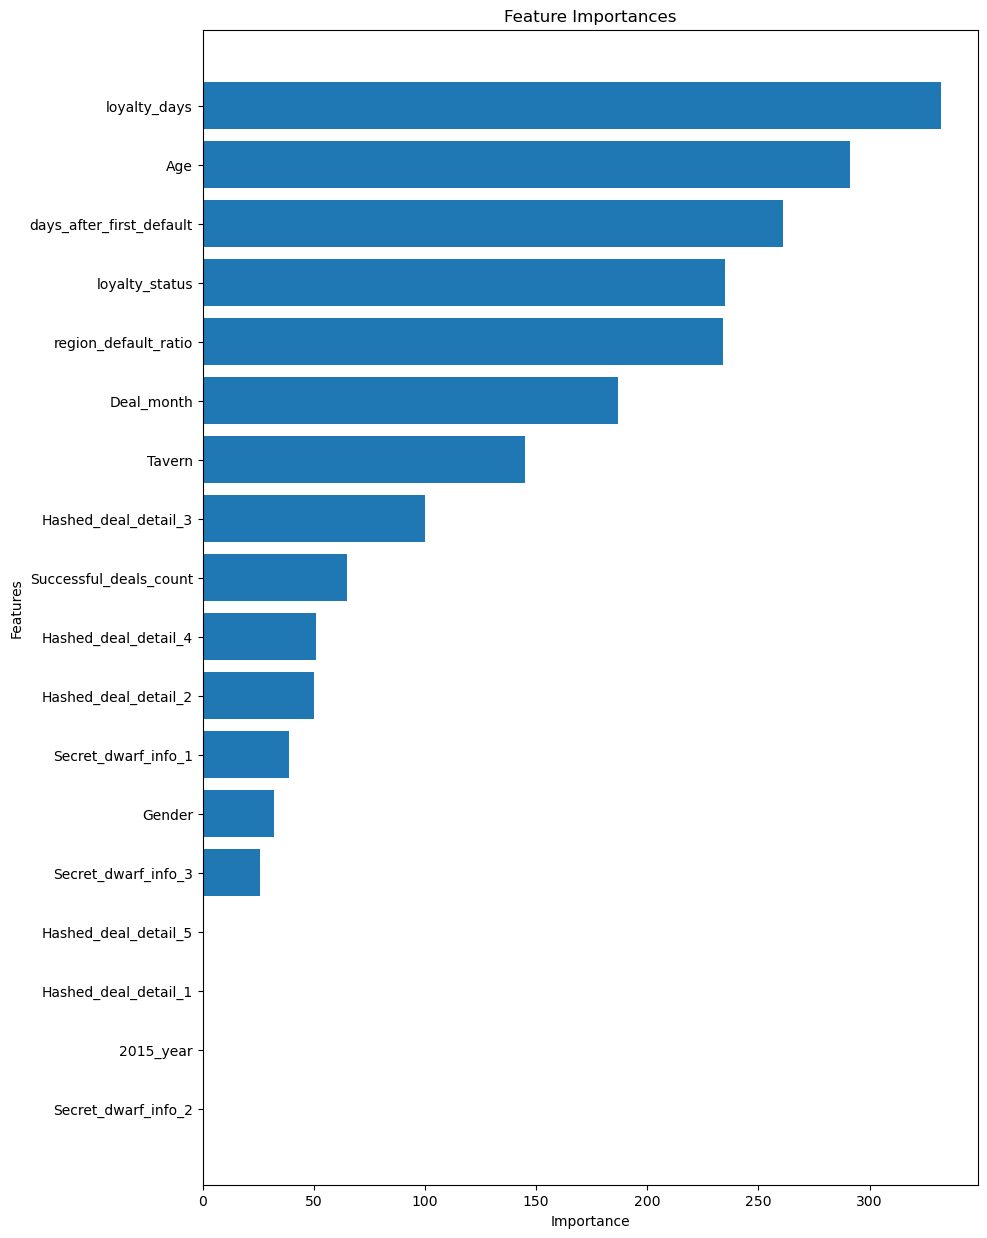

In [66]:
import matplotlib.pyplot as plt

feature_importances = search_lgb.best_estimator_.feature_importances_

feature_names = X_train.columns

sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 15))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

Just as a reminder we added the following features:
* 'loyalty_days' (interval between the fist deal and current order date)
* 'days_after_first_default' (interval between the fist default and current order date)
* 'region_default_ratio' (mean value of target variable for each tavern region)

**Conclusions:**
1. As we can see, the features that we added are on highest positions.
2. Age and tavern type are also in top, as we assumed.

Now let's train the best estimator on all data and make predictions for test dataframe.

In [67]:
mismatched_columns = [col for col in X_train.columns if X_train[col].dtype != X_test[col].dtype]
print(f"Columns with mismatched data types: {mismatched_columns}")

Columns with mismatched data types: ['Secret_dwarf_info_3', 'Tavern', 'Hashed_deal_detail_3']


In [68]:
for col in mismatched_columns:
    X_test[col] = X_test[col].astype(X_train[col].dtype)

Just in case check the types in each column.

In [69]:
mismatched_columns = [col for col in X_train.columns if X_train[col].dtype != X_test[col].dtype]
print(f"Columns with mismatched data types: {mismatched_columns}")

Columns with mismatched data types: []


In [70]:
full_train = pd.concat([X_train, X_test], axis=0)
full_train.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Deal_month,2015_year,loyalty_days,days_after_first_default,region_default_ratio,loyalty_status
Deal_id,,,,,,,,,,,,,,,,,,
20274428,3.5,-2.0,5.0,0.0,23,2.5,-2,5,2.5,-3,35.0,Female,10,1,33,-1.0,0.127059,0.277179
5503051,3.5,-2.0,5.0,0.0,7,2.5,-3,7,2.5,-3,30.0,Female,6,0,90,-1.0,0.127059,0.500835
61955513,3.5,-2.0,5.0,0.0,7,2.5,-3,8,2.5,-3,29.0,Female,8,0,87,-1.0,0.127059,0.484140
57389760,3.5,-2.0,5.0,0.0,7,2.5,-3,7,2.5,-3,44.0,Female,7,0,89,-1.0,0.127059,0.495270
49759381,3.5,-2.0,5.0,0.0,39,2.5,-3,8,2.5,-3,23.0,Female,5,0,155,-1.0,0.093567,0.859766


In [71]:
all_target = pd.concat([y_train, y_test], axis=0)

In [72]:
lgb_classifier = lgb.LGBMClassifier(class_weight='balanced')  

lgb_parameters_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.1, 0.01],
    'reg_lambda': [None, 1, 2]
}

search_lgb = GridSearchCV(
    lgb_classifier,
    lgb_parameters_grid,
    scoring="balanced_accuracy",
    return_train_score=True,
    verbose = 3
)

search_lgb.fit(full_train, all_target)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.830, test=0.704) total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.824, test=0.715) total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.819, test=0.663) total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.828, test=0.660) total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=None;, score=(train=0.820, test=0.633) total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=1;, score=(train=0.829, test=0.690) total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_lambda=1;, score=(train=0.816, test=0.720) total time=   0.1s
[CV 3/5] END learnin

[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=None;, score=(train=0.922, test=0.610) total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=None;, score=(train=0.933, test=0.604) total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.937, test=0.662) total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.934, test=0.661) total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.920, test=0.628) total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.917, test=0.626) total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1;, score=(train=0.926, test=0.599) total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=2;, score=(train=

[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=1;, score=(train=0.965, test=0.626) total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=1;, score=(train=0.958, test=0.594) total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=1;, score=(train=0.959, test=0.637) total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=1;, score=(train=0.961, test=0.597) total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=2;, score=(train=0.958, test=0.643) total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=2;, score=(train=0.961, test=0.610) total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=2;, score=(train=0.958, test=0.602) total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, reg_lambda=2;, score=(train=0.959,

[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1;, score=(train=0.744, test=0.668) total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.732, test=0.719) total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.724, test=0.749) total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.738, test=0.641) total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.739, test=0.660) total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=2;, score=(train=0.742, test=0.668) total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=300, reg_lambda=None;, score=(train=0.759, test=0.728) total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=300, reg_lambda=None;, score

[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=2;, score=(train=0.773, test=0.679) total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=2;, score=(train=0.801, test=0.658) total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=2;, score=(train=0.780, test=0.665) total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.845, test=0.683) total time=   0.9s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.845, test=0.694) total time=   0.9s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.829, test=0.645) total time=   0.9s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=None;, score=(train=0.838, test=0.652) total time=   0.9s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=300, reg_lambda=Non

[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.902, test=0.679) total time=   1.3s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.904, test=0.690) total time=   1.3s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.897, test=0.610) total time=   1.3s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.881, test=0.664) total time=   1.4s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=None;, score=(train=0.890, test=0.627) total time=   1.3s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=1;, score=(train=0.893, test=0.680) total time=   1.3s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=1;, score=(train=0.889, test=0.688) total time=   1.3s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=300, reg_lambda=

GridSearchCV(estimator=LGBMClassifier(class_weight='balanced'),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500, 700],
                         'reg_lambda': [None, 1, 2]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [73]:
df_to_predict = pd.read_csv("data/test.csv", parse_dates=[1, 2, 6])
df_to_predict = df_to_predict.set_index('Deal_id')
df_to_predict.head()

,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender
Deal_id,,,,,,,,,,,,,,,,,
72875713,2016-10-14,2015-09-20,NaN,NaN,NaN,NaT,0.0,Tavern_district_2,7,2.5,-3,18,2.5,-3,5,40.0,Female
75825544,2016-10-23,2015-06-16,NaN,NaN,NaN,NaT,6.0,Tavern_district_3,18,2.5,-2,15,3.5,-3,5,66.0,Female
81809181,2016-11-17,2016-09-11,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,2.5,-3,7,2.5,-3,5,36.0,Female
87083256,2016-12-26,2016-06-25,NaN,NaN,NaN,NaT,0.0,Tavern_district_4,7,2.5,-2,6,2.5,2,5,32.0,Female
84651519,2016-12-07,2016-10-15,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,2.5,-3,6,2.5,-3,5,37.0,Female


In [74]:
df_to_predict['Deal_month'] = df_to_predict['Deal_date'].dt.month.astype('object')
df_to_predict['Deal_year'] = df_to_predict['Deal_date'].dt.year
df_to_predict['2015_year'] = (df_to_predict['Deal_year'] == 2015).astype(int)
df_to_predict = df_to_predict.drop('Deal_year', axis = 1)
df_to_predict['loyalty_days'] = (df_to_predict['Deal_date'] - df_to_predict['First_deal_date']).dt.days
df_to_predict['days_after_first_default'] = (df_to_predict['Deal_date'] - df_to_predict['First_default_date']).dt.days
df_to_predict['days_after_first_default'] = df_to_predict['days_after_first_default'].fillna(-1)

In [75]:
df_to_predict['region_default_ratio'] = df_to_predict['Region'].map(region_default_ratio)

In [76]:
df_to_predict['tavern_loyalty_ratio'] = df_to_predict['Tavern'].map(tavern_loyalty_ratio)
df_to_predict['loyalty_status'] = df_to_predict['loyalty_days'] / df_to_predict['tavern_loyalty_ratio']
df_to_predict = df_to_predict.drop('tavern_loyalty_ratio', axis=1)

df_to_predict.head()

,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,...,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Deal_month,2015_year,loyalty_days,days_after_first_default,region_default_ratio,loyalty_status
Deal_id,,,,,,,,,,,,,,,,,,,,,
72875713,2016-10-14,2015-09-20,NaN,NaN,NaN,NaT,0.0,Tavern_district_2,7,2.5,...,-3,5,40.0,Female,10,0,390,-1.0,0.061644,2.170284
75825544,2016-10-23,2015-06-16,NaN,NaN,NaN,NaT,6.0,Tavern_district_3,18,2.5,...,-3,5,66.0,Female,10,0,495,-1.0,0.127059,2.979219
81809181,2016-11-17,2016-09-11,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,2.5,...,-3,5,36.0,Female,11,0,67,-1.0,0.127059,0.372844
87083256,2016-12-26,2016-06-25,NaN,NaN,NaN,NaT,0.0,Tavern_district_4,7,2.5,...,2,5,32.0,Female,12,0,184,-1.0,0.152672,1.023929
84651519,2016-12-07,2016-10-15,NaN,NaN,NaN,NaT,0.0,Tavern_district_3,7,2.5,...,-3,5,37.0,Female,12,0,53,-1.0,0.127059,0.294936


In [77]:
cols_to_drop = ['Hashed_deal_detail_6',
                'Deal_date',
                'First_deal_date',
                'First_default_date',
                'Region']
df_to_predict = df_to_predict.drop(cols_to_drop, axis=1)
df_to_predict.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Deal_month,2015_year,loyalty_days,days_after_first_default,region_default_ratio,loyalty_status
Deal_id,,,,,,,,,,,,,,,,,,
72875713,NaN,NaN,NaN,0.0,7,2.5,-3,18,2.5,-3,40.0,Female,10,0,390,-1.0,0.061644,2.170284
75825544,NaN,NaN,NaN,6.0,18,2.5,-2,15,3.5,-3,66.0,Female,10,0,495,-1.0,0.127059,2.979219
81809181,NaN,NaN,NaN,0.0,7,2.5,-3,7,2.5,-3,36.0,Female,11,0,67,-1.0,0.127059,0.372844
87083256,NaN,NaN,NaN,0.0,7,2.5,-2,6,2.5,2,32.0,Female,12,0,184,-1.0,0.152672,1.023929
84651519,NaN,NaN,NaN,0.0,7,2.5,-3,6,2.5,-3,37.0,Female,12,0,53,-1.0,0.127059,0.294936


In [78]:
all_cols = full_train.columns.tolist()
all_cols

['Secret_dwarf_info_1',
 'Secret_dwarf_info_2',
 'Secret_dwarf_info_3',
 'Successful_deals_count',
 'Tavern',
 'Hashed_deal_detail_1',
 'Hashed_deal_detail_2',
 'Hashed_deal_detail_3',
 'Hashed_deal_detail_4',
 'Hashed_deal_detail_5',
 'Age',
 'Gender',
 'Deal_month',
 '2015_year',
 'loyalty_days',
 'days_after_first_default',
 'region_default_ratio',
 'loyalty_status']

In [79]:
mismatched_columns = [col for col in full_train.columns if full_train[col].dtype != df_to_predict[col].dtype]
print(f"Columns with mismatched data types: {mismatched_columns}")

Columns with mismatched data types: ['Secret_dwarf_info_3', 'Tavern', 'Hashed_deal_detail_3', 'Gender', 'Deal_month']


In [80]:
for col in mismatched_columns:
    df_to_predict[col] = df_to_predict[col].astype(full_train[col].dtype)

In [81]:
mismatched_columns = [col for col in full_train.columns if full_train[col].dtype != df_to_predict[col].dtype]
print(f"Columns with mismatched data types: {mismatched_columns}")

Columns with mismatched data types: []


In [82]:
df_to_predict = df_to_predict[all_cols]

In [83]:
probabilities = search_lgb.predict_proba(df_to_predict)
first_class_probabilities = probabilities[:, 1]
df_to_predict['Prediction'] = first_class_probabilities
df_to_predict.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Deal_month,2015_year,loyalty_days,days_after_first_default,region_default_ratio,loyalty_status,Prediction
Deal_id,,,,,,,,,,,,,,,,,,,
72875713,NaN,NaN,NaN,0.0,7,2.5,-3,18,2.5,-3,40.0,Female,10,0,390,-1.0,0.061644,2.170284,0.241626
75825544,NaN,NaN,NaN,6.0,18,2.5,-2,15,3.5,-3,66.0,Female,10,0,495,-1.0,0.127059,2.979219,0.154961
81809181,NaN,NaN,NaN,0.0,7,2.5,-3,7,2.5,-3,36.0,Female,11,0,67,-1.0,0.127059,0.372844,0.595715
87083256,NaN,NaN,NaN,0.0,7,2.5,-2,6,2.5,2,32.0,Female,12,0,184,-1.0,0.152672,1.023929,0.493559
84651519,NaN,NaN,NaN,0.0,7,2.5,-3,6,2.5,-3,37.0,Female,12,0,53,-1.0,0.127059,0.294936,0.639868


In [84]:
answers = df_to_predict.drop(all_cols, axis=1)
answers.head()

,Prediction
Deal_id,
72875713,0.241626
75825544,0.154961
81809181,0.595715
87083256,0.493559
84651519,0.639868


In [85]:
answers.to_csv('answers.csv')